Running SPYDERMESH as the main code:
stretching
stretching
List of indices for polygon vertices
[0, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 2, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 2, 4, 6, 8]
[0, 1, 3, 4, 5, 7, 8]
[0, 1, 3, 4, 5, 7, 8]
[0, 1, 3, 4, 5, 7, 8]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
[[2, 1, 0, 83, 2]]


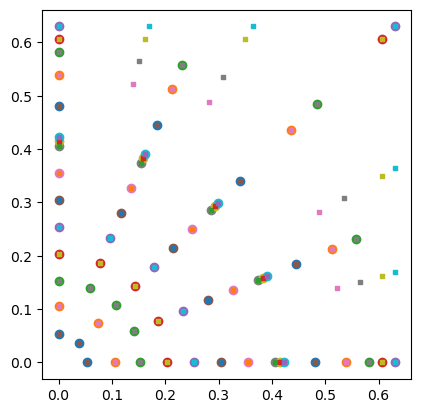

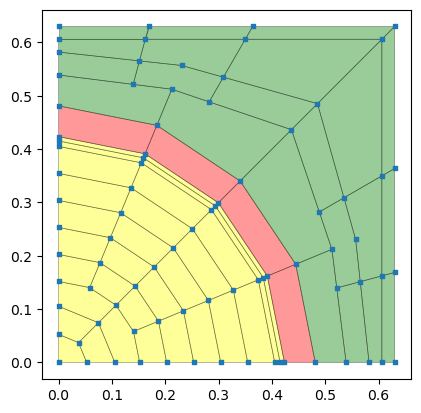

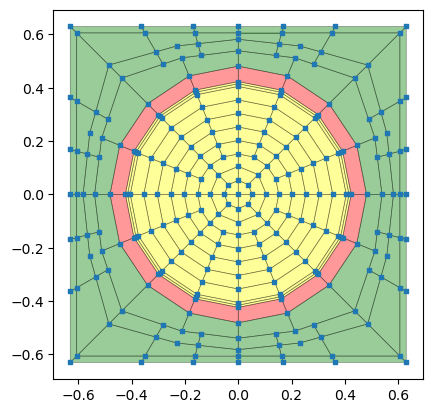

Asum error= 6.661338147750939e-16
0


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 11 08:59:47 2023

@author: jean.ragusa
"""
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

import copy as copy

plt.close("all")


class spydermesh:
    def __init__(self, pitch, pin_name):
        # pin pitch
        self.pitch = pitch
        # pin name
        self.name = pin_name
        # vertices per ring
        self.vert = []
        # angles, per ring
        self.ang = []
        # materials, per ring
        self.mat_ring = []
        # material-polgon map
        self.mat_poly = []
        # sectors, per ring
        self.n_sectors_per_ring = []
        # sectorization, per ring (excluding 0 and 90 angles)
        self.ray_angle_per_ring = []

    def polygonalize_circle(
        self, R, n, mat, half_shift=False, preserve_vol=True, stretch=[], verbose=False
    ):
        # R: true radius of the circle
        # n: number of subdivisions in [0 , pi/2]
        #       0 means points at 0 and 90 degrees only,
        #       1 means points at 0, 45, and 90 degrees, and so forth
        # half_shift:
        #      shift by half delta in angle
        # preserve vol: whether polygon should preserve area of circle
        # stretch: to be used for the water zone, past the clad/guide tube

        if R >= self.pitch:
            raise Exception("not ready for radius > pitch")
        if type(n) != int:
            raise Exception("n should be an integer")
        if n < 0:
            raise Exception("n must be positive")
        # compute the angles
        n_angles = 2 + n
        ang = np.linspace(0, np.pi / 2, n_angles)
        if half_shift:
            dphi = ang[1] - ang[0]
            ang += dphi / 2
            ang_aux = ang[:-1]
            n_angles += 1
            ang = np.zeros(n_angles)
            ang[1:-1] = ang_aux[:]
            ang[-1] = np.pi / 2
        # compute new R if volume is preserved
        if preserve_vol:
            quarter_circle_area = np.pi * R ** 2 / 4
            if not half_shift:

                def fx(r):
                    return np.cos(ang) * r

                def fy(r):
                    return np.sin(ang) * r

                # one more point to have the origin (0,0)

                def poly_area(r):
                    return np.abs(
                        self.PolyArea(
                            np.insert(fx(r), 0, 0.0), np.insert(fy(r), 0, 0.0)
                        )
                        - quarter_circle_area
                    )

            else:

                def poly_area(r):
                    return np.abs(
                        self.shifted_PolyArea(r, ang[1:-1]) - quarter_circle_area
                    )

            # solve
            res = minimize(poly_area, R)
            # print(res,res.x[0])
            R = res.x[0]
        if verbose:
            print("radius = ", R, "\n\t", ang)
        # compute vertices of polygon (excluding origin)
        vert = np.zeros((n_angles, 2))
        vert[:, 0], vert[:, 1] = np.cos(ang) * R, np.sin(ang) * R
        if half_shift:
            # projection on x-axis to have initial segment perp to axis
            vert[0, 0] = vert[1, 0]
            # projection on y-axis
            vert[-1, 1] = vert[-2, 1]
        if verbose:
            print("vert\n", vert)
        # stretching in the moderator (past cladding)
        if stretch != []:
            print("stretching")
            if preserve_vol:
                raise Exception("Cannot use preserve_vol AND stretch at the same time!")
            if stretch < 0 or stretch > 1:
                raise Exception("stretch factor must be in [0,1]")
            # stupid way of adding the Adams way after the fact
            if np.abs(stretch - 0.123456789) > 1e-9:
                for a, v in zip(ang, vert):
                    # point on circle: x0 = R*cos(a), y0 = R*sin(a)
                    # if a<45, 100% stretch would give
                    #          x=pitch and
                    #          y is s.t. cos(a) = p / sqrt(p**2 + y**2)
                    # Thus a stretch s between 0 and 1 would gives x between x0 and pitch
                    #         x = x0 + s*(pitch-x0)
                    # Finally, we get y from the cosine(angle):
                    #         y = x * np.sqrt(1/ca**2 -1)
                    #              where ca = np.cos(a)
                    if a <= np.pi / 4 + 1e-10:
                        # new x
                        v[0] += stretch * (self.pitch - v[0])
                        # cos(ang)
                        ca = np.cos(a)
                        # new y
                        v[1] = v[0] * np.sqrt(1 / ca ** 2 - 1)
                    else:
                        # new y
                        v[1] += stretch * (self.pitch - v[1])
                        # cos(pi/2-ang)
                        cb = np.cos(np.pi / 2 - a)
                        # new x
                        v[0] = v[1] * np.sqrt(1 / cb ** 2 - 1)
            else:
                # unfinished (not sure anymore what I wanted to do!)
                for a, v, vp in zip(ang, vert, self.vert[-1]):
                    delta = self.pitch - vp
        # save in object
        self.vert.append(vert)
        self.ang.append(ang)
        self.mat_ring.append(mat)

    def shifted_PolyArea(self, r, ang):
        x, y = np.cos(ang) * r, np.sin(ang) * r
        # projection on x-axis to have initial segment perp to axis
        x = np.insert(x, 0, x[0])
        y = np.insert(y, 0, 0.0)
        # origin
        x = np.insert(x, 0, 0.0)
        y = np.insert(y, 0, 0.0)
        # projection on y-axis
        x = np.append(x, 0.0)
        y = np.append(y, y[-1])

        return self.PolyArea(x, y)

    def PolyArea(self, x, y):
        # https://en.wikipedia.org/wiki/Shoelace_formula
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    def PolyArea_noabs(self, x, y):
        # https://en.wikipedia.org/wiki/Shoelace_formula
        return 0.5 * (np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    def add_corner_verts(self, mat, p=None):
        # mat: material name
        # p  : side length of square. if not given, use half-pitch value
        if p == None:
            p = self.pitch
        vert = np.zeros((3, 2))
        vert[0, :] = p, 0.0
        vert[1, :] = p, p
        vert[2, :] = 0.0, p
        self.vert.append(vert)
        self.ang.append(np.array([0.0, np.pi / 4, np.pi / 2]))
        self.mat_ring.append(mat)

    def add_sector_intersection(
        self, n_sectors, ring_id, half_shift=False, verbose=False
    ):
        if type(n_sectors) != int:
            raise Exception("n_sectors should be an integer")
        if type(ring_id) != int:
            raise Exception("ring_id should be an integer")
        if ring_id > len(self.vert) - 1:
            raise Exception(
                "ring_id[{0}] > len(self.vert)-1 [{1}]".format(
                    ring_id, len(self.vert) - 1
                )
            )
        # at the beginning, that array is empty, so we set it up
        if len(self.n_sectors_per_ring) == 0:
            self.n_sectors_per_ring = np.zeros(len(self.vert), dtype=int)
        # at the beginning, that array is empty, so we set it up
        if len(self.ray_angle_per_ring) == 0:
            self.ray_angle_per_ring = [None] * len(self.vert)
        # compute number of sectors for current ring, accounting for half shift
        self.n_sectors_per_ring[ring_id] = n_sectors
        if half_shift and n_sectors > 0:
            self.n_sectors_per_ring[ring_id] = n_sectors + int(half_shift)
        # compute angles of the rays/sectors.
        # the sectorization, per ring, excludes the 0 and 90 angles
        ray_ang = np.linspace(0, np.pi / 2, n_sectors + 2)
        if half_shift and n_sectors > 0:
            dphi = ray_ang[1] - ray_ang[0]
            ray_ang += dphi / 2
            ray_ang = np.delete(ray_ang, -1)
        else:
            ray_ang = np.delete(ray_ang, [0, -1])
        self.ray_angle_per_ring[ring_id] = ray_ang[:]

        # the sectors to be added will affect the polygonalized circles at R_i and R_{i-1}
        # the area will not change but the number of vertices per polygon may increase.
        # first, we get the ids of the ring(s) of interest
        ring_list = [ring_id]
        if ring_id > 0:
            ring_list.append(ring_id - 1)
        # then, we loop over the rings
        for ring in ring_list:
            # get angles current on the polygonalized circle
            a = self.ang[ring]
            # get its vertices
            v = self.vert[ring]
            # indices will be useful later to create polygons
            ind = [0]
            # loop over ray_angles and check if a ray_angle is found in the ring angles
            for rang in ray_ang:
                iend = np.where(a <= rang)[0]
                # the sector goes through an existing vertex of the polygonalized circle
                if np.abs(rang - a[iend[-1]]) < 1e-6:
                    ind.append(iend[-1])
                # a new vertex must be added
                else:
                    v1 = v[iend[-1], :]
                    v2 = v[iend[-1] + 1, :]
                    big = 10.0
                    v3 = self.findIntersection(
                        v1[0],
                        v1[1],
                        v2[0],
                        v2[1],
                        0.0,
                        0.0,
                        big * np.cos(rang),
                        big * np.sin(rang),
                    )
                    v = np.insert(v, iend[-1] + 1, v3, axis=0)
                    a = np.insert(a, iend[-1] + 1, rang)
                    ind.append(iend[-1] + 1)
                # print(v)
                # print(ind)
            # last polygon on that ring
            ind.append(len(v) - 1)
            # print(ind)
            # update vertex/angle array in object
            if verbose:
                print("vert inter=\n", v)
            self.vert[ring] = np.copy(v)
            self.ang[ring] = np.copy(a)

    def true_zeros_in_vert(self):
        for ir in range(len(self.vert)):
            for iv in range(len(self.vert[ir])):
                if np.fabs(self.vert[ir][iv][0]) < 1e-6:
                    self.vert[ir][iv][0] = 0.0
                if np.fabs(self.vert[ir][iv][1]) < 1e-6:
                    self.vert[ir][iv][1] = 0.0

    def collect_all_vertices(self, verbose=False):
        # avoid small round off
        self.true_zeros_in_vert()
        # start collecting all vertices
        n_vert = 0
        for v_list in self.vert:
            n_vert += len(v_list)
        self.vertices = np.zeros((n_vert, 2))
        ibeg = 0
        for v_list in self.vert:
            iend = ibeg + len(v_list)
            self.vertices[ibeg:iend, :] = np.copy(v_list)
            ibeg = iend
            if verbose:
                print("v collect\n", v_list)
        if verbose:
            print("v all\n", self.vertices)
        # self.vertices = np.unique(self.vertices, axis=1)

    def make_polygons(self, verbose=False):
        # get the list of vertex indices to make polygons per ring
        list_ind = []
        for ring_id, n_sectors in enumerate(self.n_sectors_per_ring):
            # compute angles of the rays/sectors
            ray_ang = self.ray_angle_per_ring[ring_id]

            ring_list = [ring_id]
            if ring_id > 0:
                ring_list = [ring_id - 1, ring_id]
            # loop over the rings
            for ring in ring_list:
                # get angles current on the polygonalized circle
                a = self.ang[ring]
                # indices will be useful later to create polygons
                ind = [0]
                for rang in ray_ang:
                    iend = np.where(a <= rang)[0]
                    # the sector goes through an existing vertex of the polygonalized circle
                    if np.abs(rang - a[iend[-1]]) < 1e-6:
                        ind.append(iend[-1])
                    # a new vertex must be added
                    else:
                        raise Exception(
                            "already went thru list of verts before. no need for new verts"
                        )
                # last polygon on that ring
                ind.append(len(a) - 1)
                list_ind.append(ind)
        print("List of indices for polygon vertices")
        for l in list_ind:
            print(l)
        # create polygons
        poly_list = []
        poly_mat = []
        for ring_id, n_sectors in enumerate(self.n_sectors_per_ring):
            # ring_id     go fetch indices in list as
            #   0          0
            #   1          1 , 2
            #   2          3 , 4
            #   3          5 , 6
            n = n_sectors + 1
            if verbose:
                print("Dealing with ring {}, with {} sectors".format(ring_id, n))
            if ring_id == 0:
                # add origin
                self.vertices = np.append(self.vertices, np.zeros((1, 2)), axis=0)
                n_vert = len(self.vertices)
                # loop over sectors (indices)
                for i in range(n):
                    # initialize poly
                    poly = []
                    ibeg = list_ind[ring_id][i]  # here, ring_id=0
                    iend = list_ind[ring_id][i + 1]
                    if verbose:
                        print("\tring {}, sector {}".format(ring_id, i))
                        print("\t", ibeg, iend)
                    # for each range of indices for the sectors, pick vertices
                    for iv in range(ibeg, iend + 1):
                        v = self.vert[0][iv]  # 0 is ring_id
                        # find that vertex id in the common array of vertices
                        a = self.vertices - v
                        ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                        if len(ind) != 1:
                            raise Exception("only one vertex should have been found")
                        poly.append(ind[0])
                    # flip so that polygon will be in clockwise ordering)
                    poly.reverse()
                    # adding origin
                    poly.append(n_vert - 1)
                    # closing polygon
                    poly_list.append(poly + [poly[0]])
                    print(poly_list)
                    poly_mat.append(self.mat_ring[ring_id])
                    # next range of indices = next polygon
                    # not needed as is done above in l.334 ibeg = iend
            else:
                # loop over indices
                for i in range(n):
                    poly = []
                    if verbose:
                        print("\tring {}, sector {}".format(ring_id, i))
                    ibeg_0 = list_ind[2 * ring_id - 1][i]
                    iend_0 = list_ind[2 * ring_id - 1][i + 1]
                    if verbose:
                        print("\t", ibeg_0, iend_0)
                    # for each range of indices, pick vertices (inner ring)
                    for iv in range(ibeg_0, iend_0 + 1):
                        v = self.vert[ring_id - 1][iv]
                        # find that vertex id in the common array of vertices
                        a = self.vertices - v
                        ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                        if len(ind) != 1:
                            raise Exception("only one vertex should have been found")
                        poly.append(ind[0])
                    # for each range of indices, pick vertices (outer ring)
                    ibeg_1 = list_ind[2 * ring_id][i]
                    iend_1 = list_ind[2 * ring_id][i + 1]
                    if verbose:
                        print("\t", ibeg_1, iend_1)
                    poly2 = []
                    for iv in range(ibeg_1, iend_1 + 1):
                        v = self.vert[ring_id][iv]
                        # find that vertex id in the common array of vertices
                        a = self.vertices - v
                        ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                        if len(ind) != 1:
                            raise Exception("only one vertex should have been found")
                        poly2.append(ind[0])
                    # flip so that polygon will be in clockwise ordering)
                    poly2.reverse()
                    # closing polygon and adding to list
                    poly_list.append(poly + poly2 + [poly[0]])
                    poly_mat.append(self.mat_ring[ring_id])
        # for l in poly_list:
        #     print('poly=',l)
        self.polygons = poly_list
        self.mat_poly = poly_mat

    def findIntersection(self, x1, y1, x2, y2, x3, y3, x4, y4):
        # return the intersection of lines (P1P2) with line (P3P4)
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / (
            (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        )
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / (
            (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        )
        return np.array([px, py])

    def plot_vertex(self, new_fig=True, with_markers=False):
        if new_fig:
            plt.figure()
        for v in self.vert:
            if not with_markers:
                plt.scatter(v[:, 0], v[:, 1])
            else:
                plt.scatter(v[:, 0], v[:, 1], marker="s", s=5)
        ax = plt.gca()
        ax.set_aspect("equal", adjustable="box")
        plt.draw()

    def plot_polygons(self, new_fig=True, colors=[], size_=5, lw_=0.5):
        if new_fig:
            plt.figure()
        ax = plt.gca()
        patches = []

        for i, list_vert in enumerate(self.polygons):
            # print(list_vert)
            if len(colors) > 0:
                polygon = Polygon(
                    self.vertices[list_vert], closed=True, color=colors[i]
                )
            else:
                polygon = Polygon(self.vertices[list_vert], closed=True)
            # ax.add_patch(polygon)
            patches.append(polygon)
        if len(colors) == 0:
            inhouse_colors = 100 * np.random.rand(len(patches))
        else:
            if len(colors) != len(patches):
                print("len(patches)=", len(patches))
                print("len(colors)=", len(colors))
                raise Exception(("len of color != len of patches"))
        if len(colors) == 0:
            p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
            p.set_array(inhouse_colors)
        else:
            p = PatchCollection(
                patches, cmap=matplotlib.cm.jet, alpha=0.4, match_original=True
            )
        p.set_edgecolor("black")
        p.set_linewidth(lw_)
        ax.add_collection(p)

        plt.scatter(self.vertices[:, 0], self.vertices[:, 1], marker="s", s=size_)

        ax.set_aspect("equal", adjustable="box")
        plt.show()

    def deploy_qpc(self, verbose=False):

        # deploy along x
        poly_list = self.polygons.copy()
        vertices = self.vertices.copy()
        mat_poly = self.mat_poly.copy()
        n_verts_qpc = len(vertices)
        n_verts = n_verts_qpc

        for mat, poly in zip(mat_poly, poly_list):
            # new vertices for new poly
            # (recall polygons are closed so we do not get the repeated last vertex)
            new_verts = vertices[poly[:-1]]
            new_verts[:, 0] *= -1
            # tentative number of new vertices
            n_vert_poly = len(new_verts)
            # new ids. set to a negative number
            new_vert_ids = -np.ones(n_vert_poly, dtype=int)
            if verbose:
                print(poly)
                print(n_verts_qpc, n_verts, n_vert_poly, "\n", new_vert_ids)
            # do not duplicate existing vertices
            local_index_deleted = []
            for i, v in enumerate(new_verts):
                # find if that vertex id is in the common array of vertices for qpc
                a = self.vertices - v
                ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                if len(ind) > 1:
                    raise Exception("only one vertex should have been found")
                elif len(ind) == 1:
                    # remove that new vertex ny assigning its current vertex ID
                    new_vert_ids[i] = ind[0]
                    # mapping between index in new_verts and vertex ID
                    local_index_deleted.append([i, ind[0]])
            # ?? decrement new vert ids based on duplicates
            # ?? new_vert_ids -= len(local_index_deleted)
            # reverse list to start from then end when deleting deuplicated vertices
            local_index_deleted.reverse()
            if verbose:
                print("to delete=", local_index_deleted)
                print("new verts before deletion", new_verts)
            for ii in local_index_deleted:
                new_verts = np.delete(new_verts, ii[0], axis=0)
                new_vert_ids[ii[0]] = ii[1]
            # at this stage, the non-duplicated vertices are in new_verts
            # now, we add new vertex IDs by incrementing n_verts
            for i in range(n_vert_poly):
                if new_vert_ids[i] < 0:
                    new_vert_ids[i] = n_verts
                    n_verts += 1
            if verbose:
                print("new verts AFTER deletion", new_verts)
                print("new verts IDs AFTER deletion", new_vert_ids)
            # close new polygon (recall we worked on the open poly)
            new_vert_ids = np.append(new_vert_ids, new_vert_ids[0])
            # update
            # reversing the list to keep cw ordering
            my_vert_list = list(new_vert_ids)
            my_vert_list.reverse()
            self.polygons.append(my_vert_list)
            self.vertices = np.vstack((self.vertices, new_verts))
            self.mat_poly.append(mat)
        # deploy along y
        poly_list = self.polygons.copy()
        vertices = self.vertices.copy()
        mat_poly = self.mat_poly.copy()
        n_verts_qpc = len(vertices)
        n_verts = n_verts_qpc

        for mat, poly in zip(mat_poly, poly_list):
            # new vertices (recall polygons are closed so we do not get the repeated last vertex)
            new_verts = vertices[poly[:-1]]
            new_verts[:, 1] *= -1
            # tentative number of new vertices
            n_vert_poly = len(new_verts)
            # new ids
            new_vert_ids = -np.ones(n_vert_poly, dtype=int)
            if verbose:
                print(poly)
                print(n_verts_qpc, n_verts, n_vert_poly, "\n", new_vert_ids)
            # do not duplicate existing vertices
            local_index_deleted = []
            for i, v in enumerate(new_verts):
                # find if that vertex id is in the common array of vertices for qpc
                a = self.vertices - v
                ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                if len(ind) > 1:
                    raise Exception("only one vertex should have been found")
                elif len(ind) == 1:
                    # remove that new vertex
                    new_vert_ids[i] = ind[0]
                    local_index_deleted.append([i, ind[0]])
            # ?? decrement new vert ids based on duplicates
            # ?? new_vert_ids -= len(local_index_deleted)
            # reverse list to start from end when deleting
            local_index_deleted.reverse()
            if verbose:
                print("to delete=", local_index_deleted)
                print("new verts before deletion", new_verts)
            for ii in local_index_deleted:
                new_verts = np.delete(new_verts, ii[0], axis=0)
                new_vert_ids[ii[0]] = ii[1]
            for i in range(n_vert_poly):
                if new_vert_ids[i] < 0:
                    new_vert_ids[i] = n_verts
                    n_verts += 1
            if verbose:
                print("new verts AFTER deletion", new_verts)
                print("new verts IDs AFTER deletion", new_vert_ids)
            # close new polygon
            new_vert_ids = np.append(new_vert_ids, new_vert_ids[0])
            # update
            # reversing the list to keep cw ordering
            my_vert_list = list(new_vert_ids)
            my_vert_list.reverse()
            self.polygons.append(my_vert_list)
            self.vertices = np.vstack((self.vertices, new_verts))
            self.mat_poly.append(mat)
        # IDs of the vertices that are on the periphery
        mask = np.zeros((len(self.vertices), 4), dtype=bool)
        counter = 0
        for dim in range(2):
            delta = np.abs(self.vertices[:, dim] - self.pitch)
            mask_ = delta < 1e-9
            mask[:, counter] = mask_
            counter += 1
            delta = np.abs(self.vertices[:, dim] + self.pitch)
            mask_ = delta < 1e-9
            mask[:, counter] = mask_
            counter += 1
        mask = np.logical_or.reduce(mask, axis=1)
        # get the indices where a vertex is along
        self.edge_vert_id = np.where(mask)[0]

    def make_vertices_unique(self):
        new_vertices = np.zeros((0, 2))
        # index to go from old/longer array to new/shorter array
        o2n = -np.ones(len(self.vertices), dtype=int)

        for i, v in enumerate(self.vertices):
            # find many times that vertex is repeated
            a = self.vertices - v
            ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
            # sanity check
            if len(ind) == 0:
                # vertex not found
                raise ValueError("vertex must be in array")
            # first vertex is automatically added to new vertices array
            if i == 0:
                new_vertices = np.vstack((new_vertices, v))
                o2n[ind] = len(new_vertices) - 1
            else:
                # check that current vertex is not already in new vertices array
                a = new_vertices - v
                ind2 = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                if len(ind2) == 0:
                    # current vertex is not yet in new array
                    new_vertices = np.vstack((new_vertices, v))
                    o2n[ind] = len(new_vertices) - 1
        # update vertices
        self.vertices = np.copy(new_vertices)
        # update polygons
        for ip, poly in enumerate(self.polygons):
            # print(ip,end=", ")
            # print(poly,end=", ")
            for iv, vid in enumerate(poly):
                self.polygons[ip][iv] = o2n[vid]
            coord = self.vertices[self.polygons[ip]]
            A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
            # print(self.polygons[ip],end=", ")
            if A < 0:
                # print(A)
                (self.polygons[ip]).reverse()
                coord = self.vertices[self.polygons[ip]]
                A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
                # print(A)
            # print(self.polygons[ip])
        # print(o2n)
        #self.o2n = np.copy(o2n)
        # recenter on (0,0)
        pt_min = np.min(self.vertices, axis=0)
        pt_max = np.max(self.vertices, axis=0)
        # current center
        pt_center = (pt_min + pt_max) / 2
        for i, v in enumerate(self.vertices):
            self.vertices[i, :] = v - pt_center
        # update the number of vertices
        self.nverts = len(self.vertices)
        
    def make_vertices_unique2(self):
        new_vertices = np.zeros((0, 2))
        # index to go from old/longer array to new/shorter array
        o2n = -np.ones(len(self.vertices), dtype=int)
        
        # Convert the list to a set for faster lookup
        edge_vert_id = set(self.edge_vert_id.flatten())
        
        # loop over vertices which, we know, are not duplicated
        print('loop over unique vertices') 
        for i, v in enumerate(self.vertices):
            if i not in edge_vert_id:
                new_vertices = np.vstack((new_vertices, v))
                o2n[i] = len(new_vertices) - 1
            
        print('loop over potentially duplicated vertices') 
        for i, iv in enumerate(self.edge_vert_id):
            # print(i,iv)
            v = self.vertices[iv,:]
            # find many times that vertex is repeated
            a = self.vertices - v
            ind = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
            # sanity check
            if len(ind) == 0:
                # vertex not found
                raise ValueError("vertex must be in array")
            # first vertex is automatically added to new vertices array
            if i == 0:
                new_vertices = np.vstack((new_vertices, v))
                o2n[ind] = len(new_vertices) - 1
            else:
                # check that current vertex is not already in new vertices array
                a = new_vertices - v
                ind2 = np.where(np.linalg.norm(a, axis=1) < 1e-10)[0]
                if len(ind2) == 0:
                    # current vertex is not yet in new array
                    new_vertices = np.vstack((new_vertices, v))
                    o2n[ind] = len(new_vertices) - 1
        # update vertices
        self.vertices = np.copy(new_vertices)
        # update polygons
        for ip, poly in enumerate(self.polygons):
            # print(ip,end=", ")
            # print(poly,end=", ")
            for iv, vid in enumerate(poly):
                self.polygons[ip][iv] = o2n[vid]
            coord = self.vertices[self.polygons[ip]]
            A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
            # print(self.polygons[ip],end=", ")
            if A < 0:
                # print(A)
                (self.polygons[ip]).reverse()
                coord = self.vertices[self.polygons[ip]]
                A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
                # print(A)
            # print(self.polygons[ip])
        # print(o2n)
        # self.o2n = np.copy(o2n)
        # recenter on (0,0)
        pt_min = np.min(self.vertices, axis=0)
        pt_max = np.max(self.vertices, axis=0)
        # current center
        pt_center = (pt_min + pt_max) / 2
        for i, v in enumerate(self.vertices):
            self.vertices[i, :] = v - pt_center
        # update the number of vertices
        self.nverts = len(self.vertices)

    def make_vertices_unique3(self):
        
        # Convert the array to a structured array with a single compound data type
        A = np.copy(self.vertices)
        A = np.round(A, decimals=7)
        A_view = A.view([('', A.dtype)] * A.shape[1])
        
        # Use np.unique to find the unique rows and get the indices to reconstruct the mapping
        B_unique, index, inverse = np.unique(A_view, return_index=True, return_inverse=True)
        
        # Convert the structured array back to a regular ndarray
        self.vertices = B_unique.view(A.dtype).reshape(-1, A.shape[1])

        # Use np.unique to find the unique rows and get the indices to reconstruct the mapping
        _, index, inverse = np.unique(A_view, return_index=True, return_inverse=True)
        
        # Use the indices to obtain the unique rows from the original array
        self.vertices = A[index]

        # # Print the unique rows
        # print("Unique rows (B):")
        # print(self.vertices)
        
        # # Print the mapping from rows of A to rows of B
        # print("Mapping from rows of A to rows of B:")
        # print(inverse)
 
        # update polygons
        for ip, poly in enumerate(self.polygons):
           # print(ip,end=", ")
           # print(poly,end=", ")
           for iv, vid in enumerate(poly):
               self.polygons[ip][iv] = inverse[vid]
           coord = self.vertices[self.polygons[ip]]
           A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
           # print(self.polygons[ip],end=", ")
           if A < 0:
               # print(A)
               (self.polygons[ip]).reverse()
               coord = self.vertices[self.polygons[ip]]
               A = self.PolyArea_noabs(coord[:, 0], coord[:, 1])
               # print(A)
           # print(self.polygons[ip])
        # print(o2n)
        # self.o2n = np.copy(o2n)
        # recenter on (0,0)
        pt_min = np.min(self.vertices, axis=0)
        pt_max = np.max(self.vertices, axis=0)
        # current center
        pt_center = (pt_min + pt_max) / 2
        for i, v in enumerate(self.vertices):
           self.vertices[i, :] = v - pt_center
        # update the number of vertices
        self.nverts = len(self.vertices)


    def export_to_obj(self, obj_name="mesh.obj"):

        with open(obj_name, "w") as f:
            f.write("# Spyderweb mesh generated with Ragusa's Python code\n")
            f.write("# number of polygons: {}\n".format(len(self.polygons)))
            f.write("# number of vertices: {}\n".format(len(self.vertices)))
            f.write(
                "# number of material attributes: {}\n".format(
                    len(np.unique(self.mat_poly))
                )
            )
            # f.write('# number of boundary markers: {}\n'.format(
            #     len(np.unique(fa2ma))))
            f.write("mtllib untitled.mtl \n")
            f.write("o main_object \n")

            # write mesh vertices
            for pt in self.vertices:
                f.write("v {} {} {}\n".format(pt[0], pt[1], 0.0))
            # write normal
            f.write("vn 0.0000 0.0000 1.0000 \n")
            # write shading
            f.write("s 1 \n")

            # write polygons per material attribute
            for m in np.unique(self.mat_poly):
                f.write("g mat{} \n".format(m))
                f.write("usemtl Mat_{} \n".format(m))
                for att, poly in zip(self.mat_poly, self.polygons):
                    if att == m:
                        # putting in ccw ordering
                        poly.reverse()
                        # converting to 1-indexing
                        f.write("f ")
                        for vID in poly[:-1]:  # must have open polygon for obj
                            f.write("{}//1 ".format(vID + 1))
                        f.write("\n")
                        # undo the ccw ordering
                        poly.reverse()
            # # find external edges (face marker>0)
            # ind = np.where(fa2ma != 0)[0]
            # fa2ma = fa2ma[ind]
            # fa2pt = fa2pt[ind, :]

            # # number of vertices in the main object
            # nvert = pt2xy.shape[0]

            # # write edges per bc attribute
            # for bdID in np.unique(fa2ma):
            #     # get bd edge vertices
            #     vert_list = []
            #     f.write('o bd_object{} \n'.format(bdID))
            #     for bdatt, face in zip(fa2ma, fa2pt):
            #         if bdatt == bdID:
            #             vert_list.append(face)
            #     vertID = np.reshape(np.asarray(vert_list), (-1,))
            #     # make vertex ID unique
            #     vertID_uniq, inv_ind = np.unique(vertID, return_inverse=True)
            #     # write vertex coordinates
            #     for v in vertID_uniq:
            #         pt = pt2xy[v, :]
            #         f.write('v {} {} {}\n'.format(pt[0], pt[1], 0.))
            #     # write lines
            #     inv_ind = np.reshape(inv_ind, (-1, 2))
            #     for edg in inv_ind:
            #         # converting to 1-indexing
            #         # adding nvert
            #         f.write('l {} {} \n'.format(edg[0]+1+nvert, edg[1]+1+nvert))
            #     # increment number of nvert used after each boundary object
            #     nvert += len(vertID_uniq)


# %%
if __name__ == "__main__":
    print("Running SPYDERMESH as the main code:")

    color_list = ["red", "yellow", "green", "blue", "pink","purple", 'tomato', 'gold', 'teal', 'mediumblue', 'royalblue', 'limegreen', 'darkorange']

    pin_type = 'mesh_1fuel_fine'

    if pin_type.lower() == 'mesh_4fuel_fine':
        myMESH = spydermesh(0.63, "F")
        # fuel pin Adams
        # radii = [0.11, 0.25, 0.39, 0.41, 0.42, 0.475]
        radii = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.418, 0.475]
        nsub = [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
        half_list = [False] * 11
        mat_list = ["fuel1", "fuel1", "fuel1", "fuel2", "fuel2","fuel2","fuel3","fuel3","fuel4","fuel4", "clad"]
        for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
            myMESH.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
        myMESH.polygonalize_circle(
            0.5, 3, "moderator", half_shift=False, preserve_vol=False, stretch=0.3
        )

        myMESH.polygonalize_circle(
            0.55, 3, "moderator", half_shift=False, preserve_vol=False, stretch=0.4
        )
        almost_pitch = np.max(myMESH.vert[-1][0])
        dp = myMESH.pitch - almost_pitch
        myMESH.add_corner_verts("moderator", p=almost_pitch + dp / 2)
        myMESH.add_corner_verts("moderator")

        myMESH.plot_vertex()

        sectors = [0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5]
        for iring, sector in enumerate(sectors):
            myMESH.add_sector_intersection(sector, iring)
        myMESH.plot_vertex(new_fig=False, with_markers=True)

        myMESH.collect_all_vertices()
        # print(myMESH.vertices,'\n')
        # print(myMESH.vertices.shape)
        myMESH.make_polygons()

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        # colors = ['red']*9
        # colors = colors + ['yellow']*4
        # colors = colors + ['green']*4
        # colors = colors + ['blue']*4
        # colors = colors + ['pink']*4
        myMESH.plot_polygons(colors=colors)

        myMESH.deploy_qpc()

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        myMESH.plot_polygons(colors=colors)

        polygons = copy.deepcopy(myMESH.polygons)
        vertices = np.copy(myMESH.vertices)
        myMESH.make_vertices_unique()
        myMESH.export_to_obj(pin_type.lower()+".obj")

    elif pin_type.lower() == 'mesh_1fuel_fine':
        myMESH = spydermesh(0.63, "F")
        # fuel pin Adams
        # radii = [0.11, 0.25, 0.39, 0.41, 0.42, 0.475]
        radii = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.418, 0.475]
        nsub = [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
        half_list = [False] * 11
        mat_list = ["fuel", "fuel", "fuel", "fuel", "fuel","fuel","fuel","fuel","fuel","fuel", "clad"]
        for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
            myMESH.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
        myMESH.polygonalize_circle(
            0.5, 3, "moderator", half_shift=False, preserve_vol=False, stretch=0.3
        )

        myMESH.polygonalize_circle(
            0.55, 3, "moderator", half_shift=False, preserve_vol=False, stretch=0.4
        )
        almost_pitch = np.max(myMESH.vert[-1][0])
        dp = myMESH.pitch - almost_pitch
        myMESH.add_corner_verts("moderator", p=almost_pitch + dp / 2)
        myMESH.add_corner_verts("moderator")

        myMESH.plot_vertex()

        sectors = [0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5]
        for iring, sector in enumerate(sectors):
            myMESH.add_sector_intersection(sector, iring)
        myMESH.plot_vertex(new_fig=False, with_markers=True)

        myMESH.collect_all_vertices()
        # print(myMESH.vertices,'\n')
        # print(myMESH.vertices.shape)
        myMESH.make_polygons()

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []    
        for id_ in mat_id:
            colors.append(color_list[id_])
        # colors = ['red']*9
        # colors = colors + ['yellow']*4
        # colors = colors + ['green']*4
        # colors = colors + ['blue']*4
        # colors = colors + ['pink']*4
        myMESH.plot_polygons(colors=colors)

        myMESH.deploy_qpc()

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        myMESH.plot_polygons(colors=colors)

        polygons = copy.deepcopy(myMESH.polygons)
        vertices = np.copy(myMESH.vertices)
        myMESH.make_vertices_unique()
        myMESH.export_to_obj(pin_type.lower()+".obj")
    

    elif pin_type.lower() == 'mesh_1fuel_coarse' :
         myMESH = spydermesh(0.63, "F")
         # fuel pin Adams
         radii = [0.15, 0.30, 0.40, 0.418, 0.475]
         nsub = [2, 2, 5, 5, 5]
         half_list = [False] * 6
         mat_list = ["fuel", "fuel", "fuel", "fuel", "clad"]
         for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
             myMESH.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
         myMESH.polygonalize_circle(
             0.5, 5, "water", half_shift=False, preserve_vol=False, stretch=0.35
         )
         almost_pitch = np.max(myMESH.vert[-1][0])
         dp = myMESH.pitch - almost_pitch
         myMESH.add_corner_verts("water", p=almost_pitch + dp / 2)
         myMESH.add_corner_verts("water")
         myMESH.plot_vertex()
         sectors = [0, 1, 1, 3, 3, 3, 3, 3]
         for iring, sector in enumerate(sectors):
             myMESH.add_sector_intersection(sector, iring)
         myMESH.plot_vertex(new_fig=False, with_markers=True)

         myMESH.collect_all_vertices()
         # print(myMESH.vertices,'\n')
         # print(myMESH.vertices.shape)
         myMESH.make_polygons()

         uniq_mat, mat_id, mat_count = np.unique(
             myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
         )
         colors = []
         for id_ in mat_id:
             colors.append(color_list[id_])
         # colors = ['red']*9
         # colors = colors + ['yellow']*4
         # colors = colors + ['green']*4
         # colors = colors + ['blue']*4
         # colors = colors + ['pink']*4
         myMESH.plot_polygons(colors=colors)

         myMESH.deploy_qpc()

         uniq_mat, mat_id, mat_count = np.unique(
             myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
         )
         colors = []
         for id_ in mat_id:
             colors.append(color_list[id_])
         myMESH.plot_polygons(colors=colors)

         polygons = copy.deepcopy(myMESH.polygons)
         vertices = np.copy(myMESH.vertices)
         myMESH.make_vertices_unique()
         myMESH.export_to_obj(pin_type.lower()+".obj")
        
    elif pin_type.lower() == 'mesh_4fuel_coarse' :
         myMESH = spydermesh(0.63, "F")
         # fuel pin Adams
         radii = [0.15, 0.30, 0.40, 0.418, 0.475]
         nsub = [2, 2, 5, 5, 5, 5]
         half_list = [False] * 6
         mat_list = ["fuel1", "fuel2", "fuel3", "fuel4", "clad"]
         for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
             myMESH.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
         myMESH.polygonalize_circle(
             0.5, 5, "water", half_shift=False, preserve_vol=False, stretch=0.35
         )
         almost_pitch = np.max(myMESH.vert[-1][0])
         dp = myMESH.pitch - almost_pitch
         myMESH.add_corner_verts("water", p=almost_pitch + dp / 2)
         myMESH.add_corner_verts("water")
         myMESH.plot_vertex()
         sectors = [0, 1, 1, 3, 3, 3, 3, 3]
         for iring, sector in enumerate(sectors):
             myMESH.add_sector_intersection(sector, iring)
         myMESH.plot_vertex(new_fig=False, with_markers=True)

         myMESH.collect_all_vertices()
         # print(myMESH.vertices,'\n')
         # print(myMESH.vertices.shape)
         myMESH.make_polygons()

         uniq_mat, mat_id, mat_count = np.unique(
             myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
         )
         colors = []
         for id_ in mat_id:
             colors.append(color_list[id_])
         # colors = ['red']*9
         # colors = colors + ['yellow']*4
         # colors = colors + ['green']*4
         # colors = colors + ['blue']*4
         # colors = colors + ['pink']*4
         myMESH.plot_polygons(colors=colors)

         myMESH.deploy_qpc()

         uniq_mat, mat_id, mat_count = np.unique(
             myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
         )
         colors = []
         for id_ in mat_id:
             colors.append(color_list[id_])
         # colors = ['red']*9
         # colors = colors + ['yellow']*4
         # colors = colors + ['green']*4
         # colors = colors + ['blue']*4
         # colors = colors + ['pink']*4
         myMESH.plot_polygons(colors=colors)

         myMESH.deploy_qpc()

         uniq_mat, mat_id, mat_count = np.unique(
             myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
         )
         colors = []
         for id_ in mat_id:
             colors.append(color_list[id_])
         myMESH.plot_polygons(colors=colors)

         polygons = copy.deepcopy(myMESH.polygons)
         vertices = np.copy(myMESH.vertices)
         myMESH.make_vertices_unique()
         myMESH.export_to_obj(pin_type.lower()+".obj")
    
    elif pin_type.lower() == 'gt' :

        myMESH = spydermesh(0.63, "G")
        # guide tube pin Adams
        # radii = [0.13, 0.25, 0.41, 0.55, 0.59]
        radii = [0.13, 0.25, 0.41, 0.5625, 0.6025]
        nsub = [1, 1, 2, 2, 2]
        half_list = [True] * 5
        mat_list = ["iwgt", "iwgt", "iwgt", "iwgt", "gt"]
        for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
            myMESH.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
        myMESH.polygonalize_circle(
            0.610, 2, "owgt", half_shift=True, preserve_vol=False, stretch=0.5
        )
        almost_pitch = np.max(myMESH.vert[-1][0])
        dp = myMESH.pitch - almost_pitch
        myMESH.add_corner_verts("owgt", p=almost_pitch + dp / 2)
        myMESH.add_corner_verts("owgt")

        myMESH.plot_vertex()

        sectors = [0, 1, 1, 2, 2, 2, 2, 3]
        for iring, sector in enumerate(sectors):
            if iring == len(sectors) - 1:
                myMESH.add_sector_intersection(sector, iring, half_shift=False)
            else:
                myMESH.add_sector_intersection(sector, iring, half_shift=True)
        myMESH.plot_vertex(new_fig=False, with_markers=True)

        myMESH.collect_all_vertices()
        # print(myMESH.vertices,'\n')
        # print(myMESH.vertices.shape)
        # print('\n')
        myMESH.make_polygons(verbose=False)

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        # colors = ['red']*11
        # colors = colors + ['yellow']*4
        # colors = colors + ['green']*4
        # colors = colors + ['blue']*4
        # colors = colors + ['pink']*4
        # colors = colors + ['orange']*4
        myMESH.plot_polygons(colors=colors)
        # myMESH.plot_polygons()

        myMESH.deploy_qpc(verbose=False)

        uniq_mat, mat_id, mat_count = np.unique(
            myMESH.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        myMESH.plot_polygons(colors=colors)

        polygons = copy.deepcopy(myMESH.polygons)
        vertices = np.copy(myMESH.vertices)
        myMESH.make_vertices_unique()
        myMESH.export_to_obj(pin_type.lower()+".obj")
        
    else:
        raise Exception(('unknown pin type {}'.format(pin_type)))
        
    # check area
    Asum = 0.0
    counter = 0
    for poly in myMESH.polygons:
        coord = myMESH.vertices[poly]
        A = myMESH.PolyArea_noabs(coord[:, 0], coord[:, 1])
        # A = myMESH.PolyArea(coord[:, 0], coord[:, 1])
        if A < 0:
            # print("\narea is <0:",A)
            # print(poly)
            counter += 1
        # print(A)
        Asum += A
    print("Asum error=", Asum - 1.26 ** 2)
    print(counter)
